In [1]:
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
import cosmology as cosmo
import corner
args = (70, 0.3, -1) # H0, Om0, w are the cosmological parameters
from scipy.stats import pearsonr

In [2]:
def read_df_style_normal(event_path):
    event = h5py.File(event_path, 'r')
    waveform = list(event.keys())[0]
    posterior_samples = event[waveform]["posterior_samples"]
    names = list(posterior_samples.dtype.names)
    df = pd.DataFrame([])
    for i in range(len(names)):
        name = names[i]
        df = pd.concat((df, pd.Series(posterior_samples[name]).rename(name)), axis=1)
    return df

def read_df_style_170817(event_path):
    event = h5py.File(event_path, 'r')
    waveform = list(event.keys())[0]
    names = event[waveform].dtype.names
    posterior_samples = event[waveform]
    df = pd.DataFrame([])
    for i in range(len(names)):
        name = names[i]
        df = pd.concat((df, pd.Series(posterior_samples[name]).rename(name)), axis=1)
        
    df["redshift"] = cosmo.redshift_func_jax(df["luminosity_distance_Mpc"].to_numpy(), 0, 1, args)
    df["mass_1_source"] = df["m1_detector_frame_Msun"]/(1+df["redshift"])
    df["mass_2_source"] = df["m2_detector_frame_Msun"]/(1+df["redshift"])
    df["mass_ratio"] = df["mass_2_source"]/df["mass_1_source"]
    df["chi_eff"] = (df["spin1"] * df["costilt1"] + df["mass_ratio"] * df["spin2"] * df["costilt2"]) / (1 + df["mass_ratio"])
    return df

In [3]:
def corner_plot(x, y, verbose = True):
    # convert to array
    x = np.array(x)
    y = np.array(y)
    
    if np.isnan(x).sum() > 0:
        if verbose:
            print("NaNs in x, cleaning up")
        y = y[~np.isnan(x)]
        x = x[~np.isnan(x)]
        
    if np.isnan(y).sum() > 0:
        if verbose:
            print("NaNs in y, cleaning up")
        x = x[~np.isnan(y)]
        y = y[~np.isnan(y)]
    
    # plot hist
    corner.hist2d(x, y)
    
    # calculate correlation
    r, p = pearsonr(x, y)
    if verbose:
        print(f"Correlation coefficient: {r:.3f}")
    return r, p

In [4]:
event_list = ["GW190425.h5", "GW170817.hdf5", "GW230529.h5", "GW200115.h5", "GW200105.h5"]
data_path = "data/PE/"


names_list = [event.split(".")[0] for event in event_list]
GW190425 = read_df_style_normal(data_path + event_list[0])
GW170817 = read_df_style_170817(data_path + event_list[1])
GW230529 = read_df_style_normal(data_path + event_list[2])
GW200115 = read_df_style_normal(data_path + event_list[3])
GW200105 = read_df_style_normal(data_path + event_list[4])

# Create combined
combined = pd.concat([GW190425, GW170817, GW230529, GW200115, GW200105], axis=0)

Theta_cut = (combined["mass_1_source"] < 3) & (combined["mass_2_source"] < 3)
Theta_cut_NSBH = None
BNS = combined[Theta_cut]
BBH = combined[~Theta_cut]

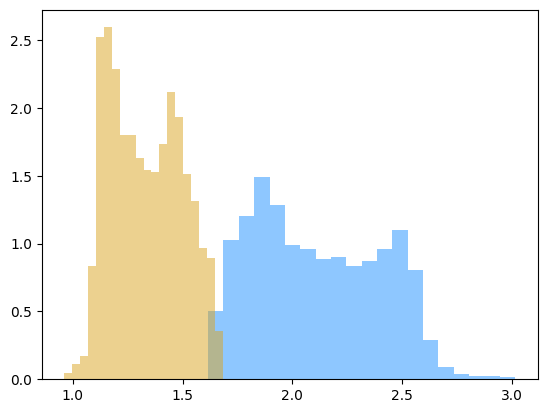

In [12]:
plt.figure()
plt.hist(GW190425["mass_1_source"], bins=20, alpha=0.5, label="mass_1", color="dodgerblue", density=True)
plt.hist(GW190425["mass_2_source"], bins=20, alpha=0.5, label="mass_1", color="goldenrod", density=True)
plt.show()

Scientific questions to ask: 

1. How strong is the correlation between mass ratio and Xeff, is it positive or negative? 
2. How strong is the correlation between m1 and Xeff, is it positive or negative?
3. How strong is the correlation between m2 and Xeff, is it positive or negative?
4. How strong is the correlation between chrip mass and Xeff, is it positive or negative?
5. How strong is the correlation between chrip mass and mass ratio, is it positive or negative?

In [17]:
events_used = combined

Correlation coefficient: -0.964


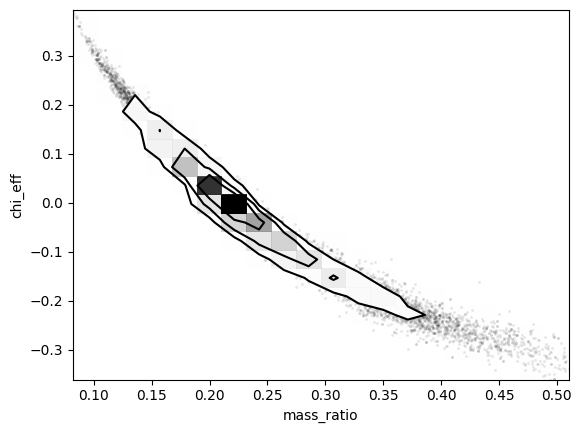

In [18]:
# How strong is the correlation between mass ratio and Xeff, is it positive or negative? 
plt.figure()
varX = "mass_ratio"
varY = "chi_eff"
corner_plot(events_used[varX], events_used[varY])
plt.xlabel(varX)
plt.ylabel(varY)
plt.show()

The correlation between mass ratio and Xeff is negative and strong. As the neutron star mass ratio increases, the effective spin decreases.

Correlation coefficient: 0.980


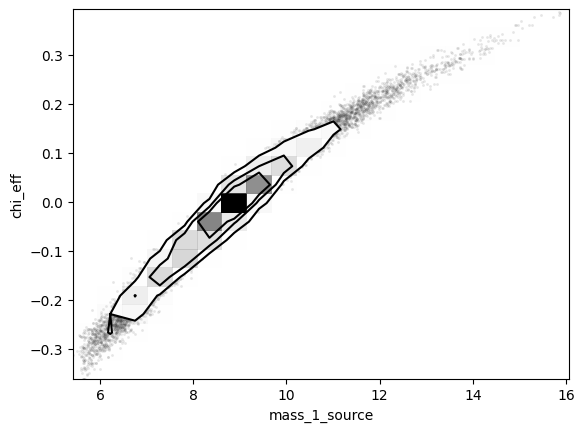

In [19]:
# How strong is the correlation between m1 and Xeff, is it positive or negative?
plt.figure()
varX = "mass_1_source"
varY = "chi_eff"
corner_plot(events_used[varX], events_used[varY])
plt.xlabel(varX)
plt.ylabel(varY)
plt.show()

Correlation coefficient: -0.973


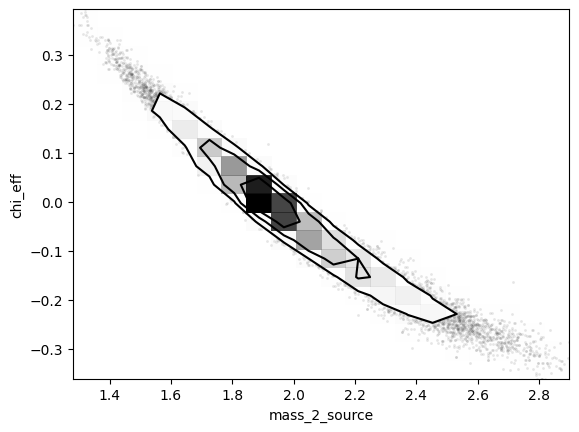

In [20]:
# How strong is the correlation between m2 and Xeff, is it positive or negative?
plt.figure()
varX = "mass_2_source"
varY = "chi_eff"
corner_plot(events_used[varX], events_used[varY])
plt.xlabel(varX)
plt.ylabel(varY)
plt.show()

Correlation coefficient: 0.861


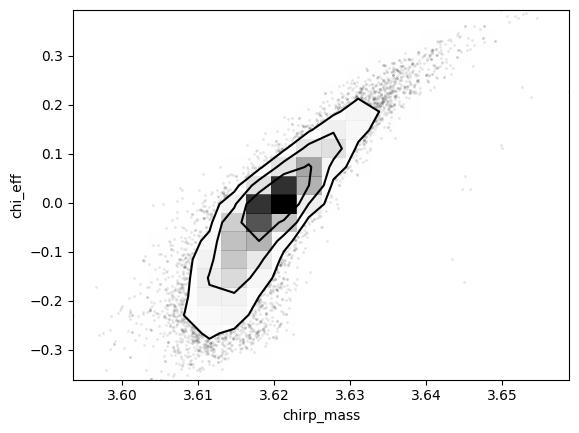

In [21]:
# How strong is the correlation between chrip mass and Xeff, is it positive or negative?
plt.figure()
varX = "chirp_mass"
varY = "chi_eff"
corner_plot(events_used[varX], events_used[varY])
plt.xlabel(varX)
plt.ylabel(varY)
plt.show()

Correlation coefficient: -0.738


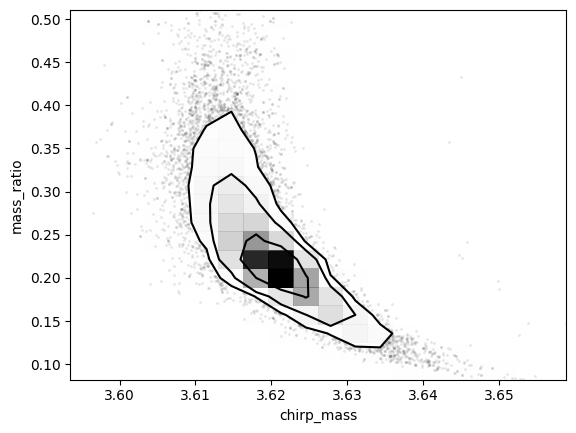

In [23]:
# How strong is the correlation between chrip mass and mass ratio, is it positive or negative?
plt.figure()
varX = "chirp_mass"
varY = "mass_ratio"
corner_plot(events_used[varX], events_used[varY])
plt.xlabel(varX)
plt.ylabel(varY)
plt.show()